# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import matplotlib
import numpy as np
import cv2
import tensorflow as tf
import random

# Load pickled data
training_file = "./train.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_file, y_train_file = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("Done!")

Done!


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

n_train = X_train_file.shape[0]

n_test = X_test.shape[0]

image_shape = X_train_file[0].shape

n_classes = len(np.unique(y_train_file))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

signnames = np.loadtxt('./signnames.csv',
                      delimiter=',',
                      skiprows=1,
                      dtype={'names': ('ClassId', 'SignName'),'formats': ('i4', 'S100')})

def class_pretty_name(class_id):
    class_id, name = signnames[class_id]
    return "Class id: {} - Name: {}".format(class_id, name.decode())

print("Done!")

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Done!


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

> First we try to visualize some samples in the training dataset. We take randonmly 6 and verify that their label assigned is correctly matched.

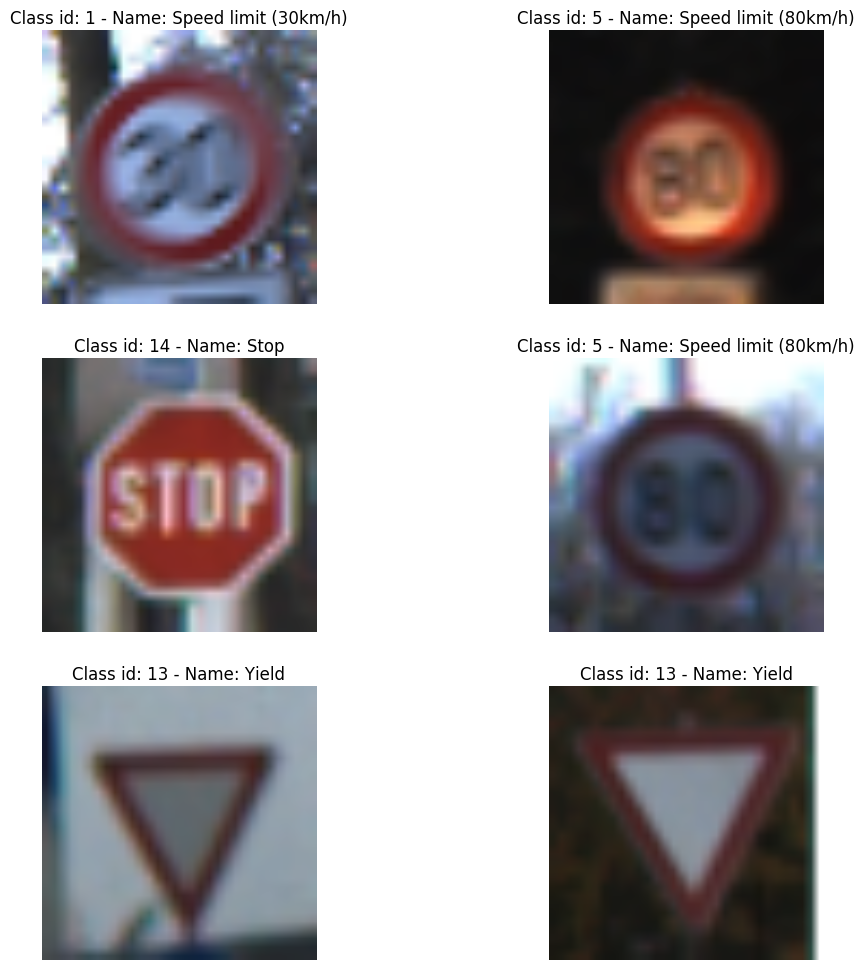

In [3]:
# Visualizing random samples
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

gs1 = gridspec.GridSpec(3, 2)
plt.figure(figsize=(12,12))

n_samples = 6
i = 0
for index in np.random.choice(n_train, n_samples):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

    img = X_train_file[index]
    class_id, name = signnames[y_train_file[index]]
    plt.title("Class id: {} - Name: {}".format(class_id, name.decode()))
    i += 1
    plt.imshow(img)
    plt.axis('off')

plt.show()

> Next, we plot an histogram of counts of observations per class. This visualization helps us to have an idea of what the distribution is so that we can later decide if it is necessary to *artificially* grow the dataset to train our model.
>
> As we observe, there are some classes with very low counts. For example, there are only 210 observations for class 0 ( Speed limit 20 kms/h).
> Giving this visualization, we decided to try some techniques to grown the dataset. More on this, later.

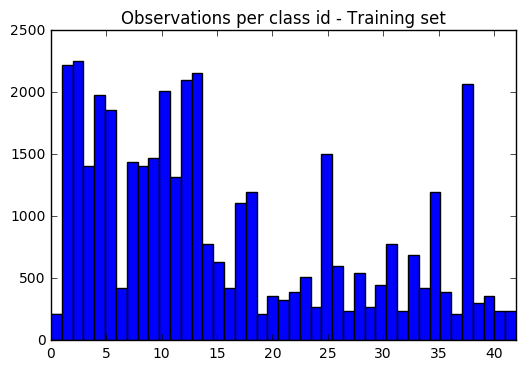

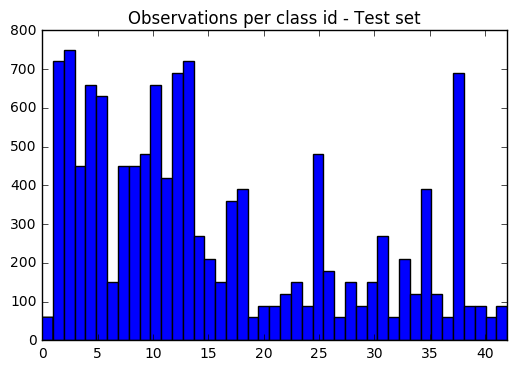

In [4]:
# count of samples per class in training set
plt.xlim([0, n_classes - 1])
plt.hist(y_train_file, bins=n_classes)
plt.title("Observations per class id - Training set")
plt.show()

plt.xlim([0, n_classes - 1])
plt.hist(y_test, bins=n_classes)
plt.title("Observations per class id - Test set")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

> First, we proceed to build aditional versions of the original data set by scaling and rotating images. This will result in a more robust learning to possible deformation in images that the model has to classify in the future.

/Users/vm.guerramoran/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(39209, 32, 32, 3)
(39209,)
(117627, 32, 32, 3)
(117627,)
Done!


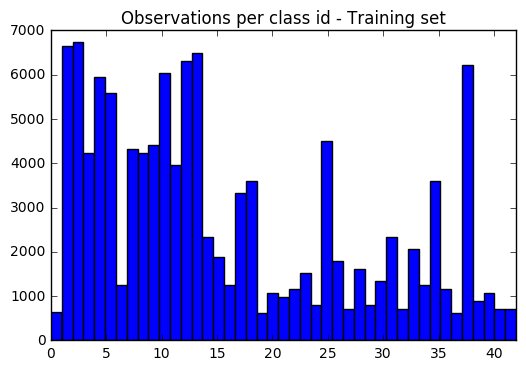

In [5]:
# Artificially growing the dataset
rotation_degrees = range(-20, 21)
scaling_factors = [0.9, 0.95, 1.0, 1.05, 1.1]

def  scale_and_crop(img, factor):
    if (factor == 1.0):
        return img
    new_img = cv2.resize(img, None,fx=factor, fy=factor, interpolation = cv2.INTER_AREA)
    size = new_img.shape[0]
    if size < 32:
        right_pad = int((32 - size)/2)
        left_pad = right_pad + (size & 1)
        new_img = np.pad(new_img, ((left_pad, right_pad), (left_pad, right_pad), (0, 0)), 'constant')
    else:
        # crop the image to 32x32xC            
        start = (size - 32)/2
        end = start + 32
        new_img = new_img[start:end, start:end]
    return new_img

def rotate(img, degrees):
    (cols, rows, _) = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(img, M, (cols, rows))

def generateDataSet(images):
    new_images = images.copy()
    for idx in range(images.shape[0]):
        scaling = random.choice(scaling_factors)
        angle = random.choice(rotation_degrees)
        scaled_img = scale_and_crop(images[idx], scaling)
        rotated_img = rotate(scaled_img, angle)
        new_images[idx] = rotated_img
    return new_images

def reproduceDataSet(images, labels, copies):
    orig_images = images.copy()
    orig_labels = labels.copy()
    for i in range(copies):
        images = np.vstack((images, generateDataSet(orig_images)))
        labels = np.hstack((labels, orig_labels))
    return images, labels

(X_train_jitt, y_train_jitt) = reproduceDataSet(X_train_file, y_train_file, 2)

print(X_train_file.shape)
print(y_train_file.shape)
print(X_train_jitt.shape)
print(y_train_jitt.shape)

y_train_file = y_train_jitt
X_train_file = X_train_jitt

print("Done!")

# count of samples per class in training set
plt.xlim([0, n_classes - 1])
plt.hist(y_train_file, bins=n_classes)
plt.title("Observations per class id - Training set")
plt.show()

In [6]:
### Preprocessing images.

def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def img_norm(img):
    img_dst = img.copy()
    return cv2.normalize(img, dst=img_dst, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

def images_to_gray(images):
    shape = images.shape
    copy = np.zeros((shape[0], shape[1], shape[2]))
    for idx in range(images.shape[0]):
        copy[idx] = rgb2gray(images[idx])
    return copy

# preprocessing dataset
def normalize_images(images):
    shape = images.shape
    copy = np.zeros((shape[0], shape[1], shape[2]))
    for idx in range(images.shape[0]):
        copy[idx] = img_norm(images[idx])
    return copy

def preprocess(images):
    pp = normalize_images(images_to_gray(images))
    return np.reshape(pp, pp.shape + (1, ))

X_train_pp = preprocess(X_train_file)
X_test = preprocess(X_test)

print(X_train_pp.shape)

print("Done!")

(117627, 32, 32, 1)
Done!


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

> The preprocessing of images in the training dataset goes through two phases:
>
>* **Transform images to gray scale:** Our model should be able to classify correctly images independently from the colors in them. Practicaly, it would not be very clever to have two kind of traffic signs with extremly similar shapes that differ from each other only by the color palete. So the color information by it self is not vital for our model to learn. Therefore, images are transformed to grayscale. 

>* **Image normalization:** In machine learning, scaling input features to standarize their range is crucial so that some features don't govern results of computations over others. As well, some optimization algorithms tend to converge faster when features are scaled. Therefore we proceed to normalize images in our tranining dataset.

In [7]:
### split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_pp, y_train_file, test_size=0.3, random_state=42)

print("Training set shape: {}".format(X_train.shape))
print("Validation set shape: {}".format(X_validation.shape))
print("Test set shape: {}".format(X_test.shape))

Training set shape: (82338, 32, 32, 1)
Validation set shape: (35289, 32, 32, 1)
Test set shape: (12630, 32, 32, 1)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

>### Generating additional data:
>We experimented with two techniques to artificially grow our training dataset, we discuss shortly on what they consist and whether they worked or not:
>
> * ** Improving distribution of observations in dataset ** : When we built the visualization of count of observations per class, we saw that there was a considerable gap among them. So intuitively we thought about artificially grow the number of observations for classes with lower counts. We tried to fill up that gap using two policies:
>    - Bring counts up to the average of observations per class.
>    - Bring counts up to maxinum number of observations among all classes.
>
>  For both variants, the new observations were generated as folllows for a given class:
>    - First, we computed tha amaount of needed samples. This depended on the policy we worked on ( using max or avg of samples per class).
>    - Then we picked an image randomly from the original dataset and the following properties were modified with random values as well, to produce a new one: 
        - Brightness
        - Rotation 
        - Translation
        - Affine transformations
>
>  Unfortunately this technique did not seem to help much. On the contrary, accuracy on the validation dataset decreased by aprox. 5%. Plus training the model took more time since we had more observations to go over.
>
>
> * ** Generating a new version of original dataset, X times ** : Based on the original dataset, we generated a new version of it by taking all images and randomly modify some properties. We repeated this task, 2 times. The transformations applied to the images were:
>    - Scaling: Using a scaling factor randomly picked in the range of [0.9 - 1.1].
>    - Rotation: Using a rotation angle randomly picked in the range of [-20 - 20] degrees.

>   The original training dataset had 39209 observations. After growing it we ended up with 117627. This technique helped us to reach a much better accuracy in the validation set. Giving a bump of almos 4%. We decided to grow the training dataset only twice since we observed that repeating the process more time did not added much value and the training times were getting longer. So the waste or resource was not worth it.


>### Dataset setup :
> We started with two datasets, a test dataset with 12630 observations and a training dataset with 39209  observations. After growing our training dataset we ended up with 117627 samples for training.
> In Machine Learning it is a good practice to spare some of our training data for a validation phase.We proceeded to split our resulting training dataset in two, leaving for training 82338 ( 70% ) observations and 35289 ( 30 % ) observations for validation.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

# German Traffic Sign Classifier
def GTSC(x, n_classes, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # returns all parameters 
    all_parameters = []
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Dropout
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return (logits, all_parameters)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

> The starting point for the model architecture was the LeNet lab solution we covered in the Udactiy course. Some minor things were adapted for it to be usable in our excersice:
* **The output size**: Our exercise needs to output results for 43 classes.
* **Dropout**: A simple and effective way of avoiding overfitting.

> The final architecture is as follows:
> * **The input**: Our network accepts 32x32x1 images as input. No color information, they are grayscale images.
> * **Layer 1**: Convolutional layer with input size 32x32x1 and output size 28x28x6.
> * **Relu** activation + **Max pooling** with input size 28x28x6 and output size 14x14x6.
> * **Layer 2**: Convolutional layer with input size 14x14x6 and output size 10x10x16
> * **Relu** activation + **Max pooling** with input size 10x10x16 and output size 5x5x16.
> * **Flatten**: to end up with vectors of size 400.
> * **Layer 3**: Fully connected with input size 400 and output size 120.
> * **Relu** activation of Layer 3.
> * **Layer 4**: Full connected with input size 120 and output size 84.
> * **Dropout** and Relu activation of Layer 4.
> * **Layer 5**: Fully connected with input size 84 and output size 43.

Trainning w/82338 observations
EPOCH 1 ...
Training Accuracy = 0.735
Validation Accuracy = 0.708
Validation loss = 0.988

EPOCH 2 ...
Training Accuracy = 0.971
Validation Accuracy = 0.855
Validation loss = 0.485

EPOCH 3 ...
Training Accuracy = 0.941
Validation Accuracy = 0.898
Validation loss = 0.343

EPOCH 4 ...
Training Accuracy = 0.941
Validation Accuracy = 0.925
Validation loss = 0.252

EPOCH 5 ...
Training Accuracy = 0.971
Validation Accuracy = 0.936
Validation loss = 0.217

EPOCH 6 ...
Training Accuracy = 0.971
Validation Accuracy = 0.953
Validation loss = 0.168

EPOCH 7 ...
Training Accuracy = 0.941
Validation Accuracy = 0.958
Validation loss = 0.147

EPOCH 8 ...
Training Accuracy = 0.971
Validation Accuracy = 0.962
Validation loss = 0.134

EPOCH 9 ...
Training Accuracy = 1.000
Validation Accuracy = 0.965
Validation loss = 0.124

EPOCH 10 ...
Training Accuracy = 1.000
Validation Accuracy = 0.966
Validation loss = 0.127

EPOCH 11 ...
Training Accuracy = 0.971
Validation Accuracy

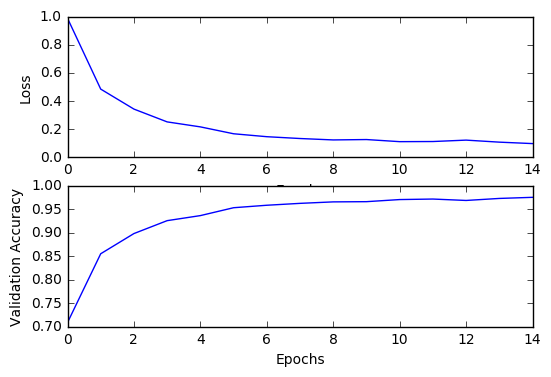

In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from sklearn.utils import shuffle

EPOCHS = 15
BATCH_SIZE = 128

# Regularization
regParam = 0.0001

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

rate = 0.001
(logits, all_parameters) = GTSC(x, n_classes, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy + sum([regParam*tf.nn.l2_loss(param) for param in all_parameters]))

optimizer = tf.train.AdamOptimizer(learning_rate = rate,
                                            beta1=0.9,
                                            beta2=0.999,
                                            epsilon=1e-08,
                                            use_locking=False,
                                            name='Adam')
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy / num_examples, total_loss / num_examples)

validation_accurracies = []
validation_losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = X_train.shape[0]

    print("Trainning w/{} observations".format(num_examples))
    
    for i in range(EPOCHS):
        X, Y = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X[offset:end], Y[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        (training_accuracy, training_loss) = evaluate(batch_x, batch_y)
        (validation_accuracy, validation_loss) = evaluate(X_validation, y_validation)
        validation_accurracies.append(validation_accuracy)
        validation_losses.append(validation_loss)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation loss = {:.3f}".format(validation_loss))
        print()
        
    saver.save(sess, 'tsc')
    print("Model saved")

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(range(EPOCHS), validation_losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")

ax2 = fig.add_subplot(212)
ax2.plot(range(EPOCHS), validation_accurracies)
ax2.set_ylabel("Validation Accuracy")
ax2.set_xlabel("Epochs")

plt.show()

> 

In [10]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, _ = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.946


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

> Some points about training the model: 
> * To train our model we opted for the Adam optimizer which computes *adaptive* learning rate for each of the parameters and implements a similar idea to [momentum link](http://www.sciencedirect.com/science/article/pii/S0893608098001166). Two characteristics that help it perform better than SGD. The optimizer needs an initial learning rate value, the value we set is 0.001. We experimented with other values but noticed that it takes longer for the algorithm to stabalize. It learnt too slow.
> * As we can observe in the Loss plot above, the graph kinds of stabilizes around 0.95 after the 10th epoch. It does not make sense to go much further so we set a value of 15 for the epochs.
> * We redefined our loss function to introduce regularization, therefore one needs to set the regularization parameter. After experimentation, we settled for a value of 0.0001.
> * We use a batch size of 128 observations which seems to be a reasonable value. If batch size is too low, then we would see a noicier error plot (due to the variance introduced). If batch size is close to the size of the training set, then it would take too long to compute the gradient for each epoch.
> * We introduced as well droupout. Which will be activated only during training. The value we settled in after experimentation is 50%.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

> The starting point for our solution was the LeNet architecture, which we know performs excellent for the classification of images. LeNet architecture uses Convolutional Neural Networks which are a kind of special multi-layer neural network. With minimal effort, this networks are capable of learning visual patterns from pixel images. One of their strongest arguments is that they recognize patterns with extreme variability and learn with robustness to distortions or geometric deformations.
> From there on, we used several techniques for regularization and pre-processing of data to tune the model for learning faster.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import os
import re


photos = glob.glob('./imgs/*.jpg')
pattern = re.compile('([0-9]+)_(.*)')

X_custom_test = np.zeros((len(photos), 32, 32, 1))
y_custom_test = []

for (idx, filepath) in enumerate(photos):
    filename = os.path.split(filepath)[-1]
    label = pattern.match(filename).group(1)
    y_custom_test.append(int(label))
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (32, 32))
    X_custom_test[idx] = np.reshape(img, img.shape + (1, ))

print(X_custom_test.shape)
print(y_custom_test)

print("Done!")

(5, 32, 32, 1)
[25, 28, 2, 31, 33]
Done!


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

> We used pictures of german signs that one of my classmates who lives in german uploaded to his [github account](https://github.com/KonArtist02/CarND-Traffic-Sign-Classifier-Project/tree/master/test_images). We took five of them to run the experiments:

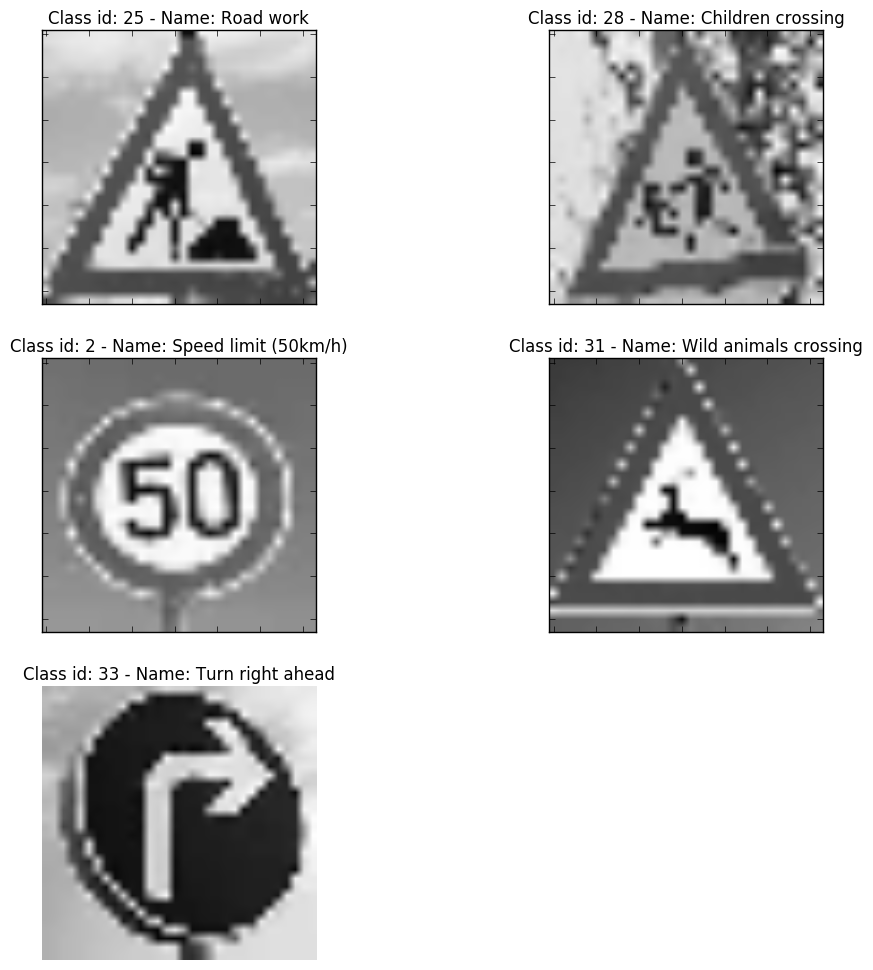

In [12]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

gs1 = gridspec.GridSpec(3, 2)
plt.figure(figsize=(12,12))

i = 0
for index in range(len(y_custom_test)):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

    img = X_custom_test[index]
    class_id, name = signnames[y_custom_test[index]]
    plt.title("Class id: {} - Name: {}".format(class_id, name.decode()))
    i += 1
    plt.imshow(np.reshape(img, (32, 32)), cmap='gray')

plt.axis('off')
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


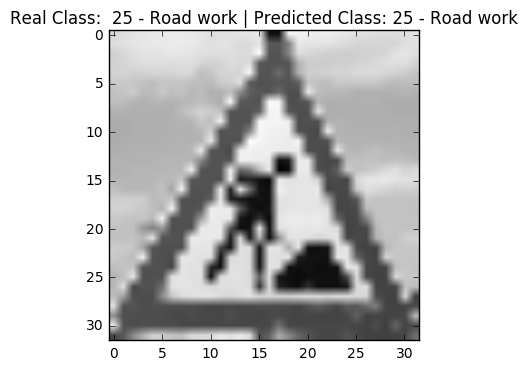

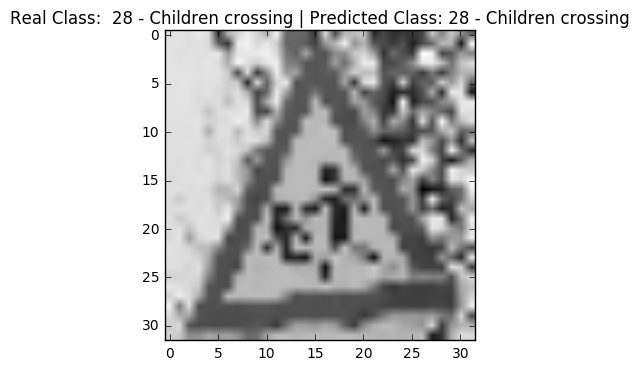

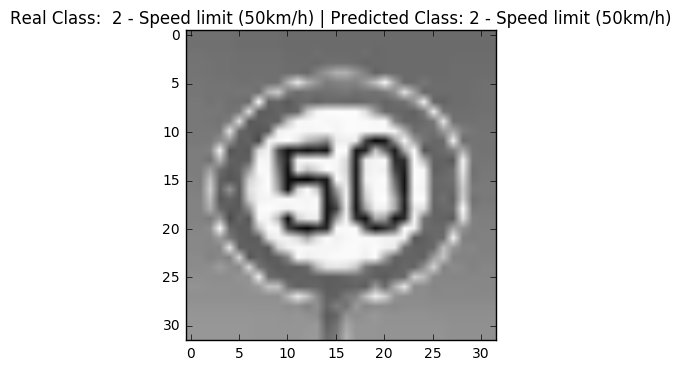

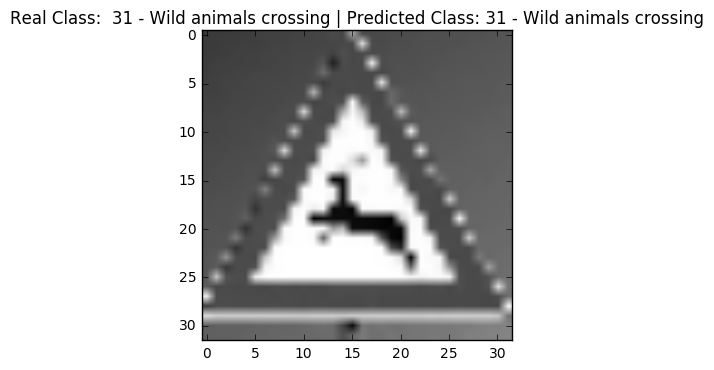

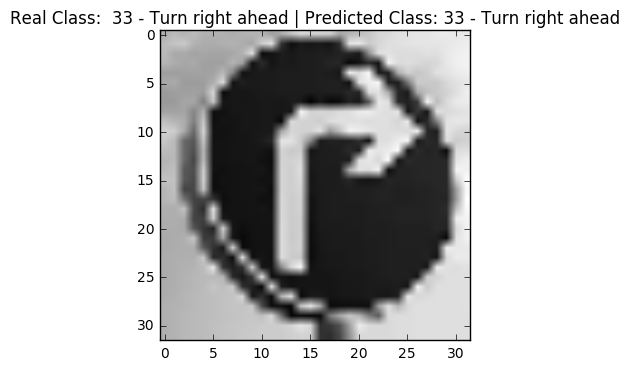

Test Accuracy = 1.000


In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    sess = tf.get_default_session()
    softmax_probs = tf.nn.softmax(logits)
    (k_values, k_indexes), probs = sess.run([tf.nn.top_k(softmax_probs, 3), softmax_probs],
                     feed_dict={x: X_custom_test, y: y_custom_test, keep_prob : 1.0})
    for idx in range(len(y_custom_test)):
        img = np.reshape(X_custom_test[idx], (32, 32))
        plt.imshow(img, cmap='gray')
        real_id = y_custom_test[idx]
        predicted_id = k_indexes[idx][0]
        plt.title("Real Class:  {} - {} | Predicted Class: {} - {}".format(
                real_id,
                signnames[real_id][1].decode(),
                predicted_id,
                signnames[predicted_id][1].decode()))

        plt.figure()
    plt.show()
    
    test_accuracy, loss = evaluate(X_custom_test, y_custom_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

In [14]:
# Helper code to plot probabilities.
def plot_probs(img_idx):
    plt.title(class_pretty_name(y_custom_test[img_idx]))
    plt.xlim([0, n_classes - 1])
    plt.plot(range(n_classes), probs[img_idx])
    plt.show()

**Answer:**

> Our model is able to classify our images with a 100% accuracy. 5 out 5 images are classified correctly. We take a look at the plots of probabilities of the classes the model assign for each image and note the spikes at the correct class label.

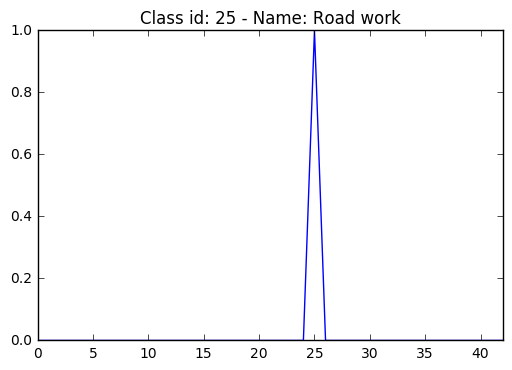

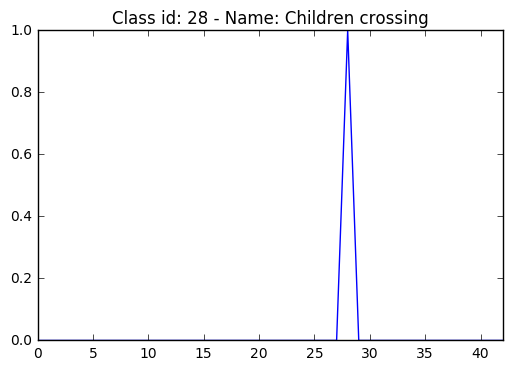

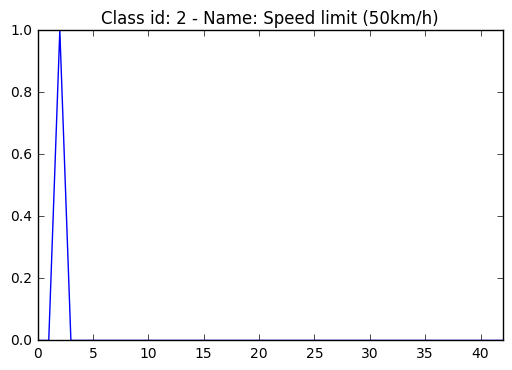

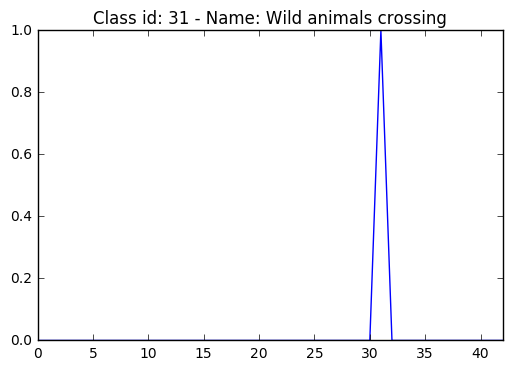

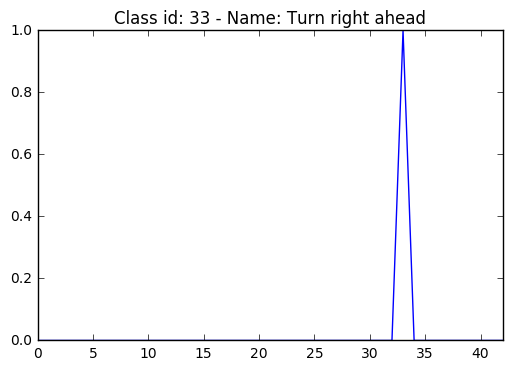

In [15]:
for img_idx in range(len(y_custom_test)):
    plot_probs(img_idx)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> For each image we will visualize what are the top 3 classes the model outputs:

In [16]:
for img_idx in (range(len(y_custom_test))):
    class_indexes = k_indexes[img_idx]
    print("Image: {}".format(
            class_pretty_name(y_custom_test[img_idx])))
    print("\t Classfied by model as: {}".format(
            class_pretty_name(class_indexes[0])))
    print("\t the other two options were: \n\t\t{} \n\t\t{}".format(
            class_pretty_name(class_indexes[1]),
            class_pretty_name(class_indexes[2])))
    print("\n")

Image: Class id: 25 - Name: Road work
	 Classfied by model as: Class id: 25 - Name: Road work
	 the other two options were: 
		Class id: 20 - Name: Dangerous curve to the right 
		Class id: 30 - Name: Beware of ice/snow


Image: Class id: 28 - Name: Children crossing
	 Classfied by model as: Class id: 28 - Name: Children crossing
	 the other two options were: 
		Class id: 36 - Name: Go straight or right 
		Class id: 20 - Name: Dangerous curve to the right


Image: Class id: 2 - Name: Speed limit (50km/h)
	 Classfied by model as: Class id: 2 - Name: Speed limit (50km/h)
	 the other two options were: 
		Class id: 1 - Name: Speed limit (30km/h) 
		Class id: 5 - Name: Speed limit (80km/h)


Image: Class id: 31 - Name: Wild animals crossing
	 Classfied by model as: Class id: 31 - Name: Wild animals crossing
	 the other two options were: 
		Class id: 23 - Name: Slippery road 
		Class id: 29 - Name: Bicycles crossing


Image: Class id: 33 - Name: Turn right ahead
	 Classfied by model as: Clas

> We see that for the all 5 images, the correct class appears within the top 3 ranked classes by our model. It is interesting to note that among the top 3, normally the classes found are visually similar. For example in the top 3 classes for the Speed limit (50 km/h) we can find as well the classes: Speed limit (60km/h) and Speed limit (80km/h), which is an interesting fact.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.